In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
df = pd.read_csv("Airbnb_data - airbnb_data.csv")
df.head()

# Check data info and statistical summary
df.info()

df.describe()

# Check null values in the dataset per column
df.isnull().sum()

# Dropping the null values from the dataset
df.dropna(inplace = True)
# check for any missing values after performing the .dropna function
df.isnull().sum()

# Dropping columns that are not necessary for further analysis
cols_to_drop = ["id", "description", "thumbnail_url"]
df.drop(columns= cols_to_drop, inplace = True)

df.columns

# Cleaning columns and converting to appropriate numerical data types
df["host_response_rate"] = df["host_response_rate"].str.rstrip("%")

# Setting up all "Date" columns datatype to date and adding a new column to calculate the total tenure
# List of columns to convert
date_cols = ["first_review", "host_since", "last_review"]
df[date_cols] = df[date_cols].apply(pd.to_datetime, format='%d-%m-%Y')
df["host_tenure"] = 2025 - df["host_since"].dt.year
df.dtypes


# Removing outliers using Interquartile range(IQR)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
# Apply to columns with potential outliers
df = remove_outliers(df, "log_price")
df = remove_outliers(df, "accommodates")
df = remove_outliers(df, "bathrooms")
df = remove_outliers(df, "bedrooms")
df = remove_outliers(df, "beds")
# final shape of the dataset after removing outliers
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

(17138, 27)

In [6]:
# Performing Feature engineering
neighborhood_counts = df['neighbourhood'].value_counts()

# Compute the average review score
neighborhood_avg_review = df.groupby('neighbourhood')['review_scores_rating'].mean()

# Normalize and combine these factors into a popularity score
df['neighborhood_popularity'] = df['neighbourhood'].map(lambda x:
                                (neighborhood_counts[x] - neighborhood_counts.min())
                                / (neighborhood_counts.max() - neighborhood_counts.min()))

df['neighborhood_avg_review'] = df['neighbourhood'].map(lambda x:
                                (neighborhood_avg_review[x] - neighborhood_avg_review.min())
                                / (neighborhood_avg_review.max() - neighborhood_avg_review.min()))

# Weighted score: 70% listings count + 30% average review score
df['neighborhood_popularity'] = (df['neighborhood_popularity'] * 0.7) +\
                                (df['neighborhood_avg_review'] * 0.3)

df[['neighbourhood', 'neighborhood_popularity']].head().reset_index(drop=True)


,neighbourhood,neighborhood_popularity
0,Noe Valley,0.322683
1,Downtown,0.315679
2,Richmond District,0.317702
3,Alphabet City,0.386873
4,Sherman Oaks,0.311005


In [7]:
# Create a new column for number of amenities
df['num_amenities'] = df['amenities'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Verify the new feature
df[['amenities', 'num_amenities']].head()

,amenities,num_amenities
5,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",10
7,"{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...",26
8,"{TV,""Cable TV"",""Wireless Internet"",""Pets live ...",21
10,"{Internet,""Wireless Internet"",""Air conditionin...",15
20,"{""Cable TV"",Internet,""Wireless Internet"",""Air ...",21


In [11]:
# Convert 'host_response_rate' from percentage string to numeric
df['host_response_rate'] = df['host_response_rate'].astype(str).str.rstrip('%').astype(float) / 100

# Create a feature for the number of days the host has been on Airbnb
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_days_active'] = (pd.to_datetime('today') - df['host_since']).dt.days

# Verify the new features
df[['host_response_rate', 'host_days_active']].head()

,host_response_rate,host_days_active
5,1.0,2856
7,1.0,4337
8,1.0,3590
10,1.0,4389
20,1.0,3369


In [282]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17138 entries, 5 to 74103
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   log_price                17138 non-null  float64       
 1   property_type            17138 non-null  object        
 2   room_type                17138 non-null  object        
 3   amenities                17138 non-null  object        
 4   accommodates             17138 non-null  int64         
 5   bathrooms                17138 non-null  float64       
 6   bed_type                 17138 non-null  object        
 7   cancellation_policy      17138 non-null  object        
 8   cleaning_fee             17138 non-null  bool          
 9   city                     17138 non-null  object        
 10  first_review             17138 non-null  datetime64[ns]
 11  host_has_profile_pic     17138 non-null  object        
 12  host_identity_verified   17138 non-nu

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [11]:
# Convert categorical features using one-hot encoding
# df = pd.get_dummies(df, columns=['city', 'neighbourhood', 'zipcode'], drop_first=True)

# Convert boolean columns to numeric
bool_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
df[bool_cols] = df[bool_cols].replace({'t': 1, 'f':0})

# Defining the target variable
y = df['log_price']

# removing some columns that are not necessary for further analysis
X = df.drop(columns=['log_price', 'name'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Set Target variable
y = df['log_price'] 
X = df.drop(columns=['log_price', 'name', 'first_review', 'last_review', 'host_since'])

# Step 2: One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)


In [37]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [39]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Root Mean Squared Error: 350959.20981379034
R-squared: -484684051173.5906


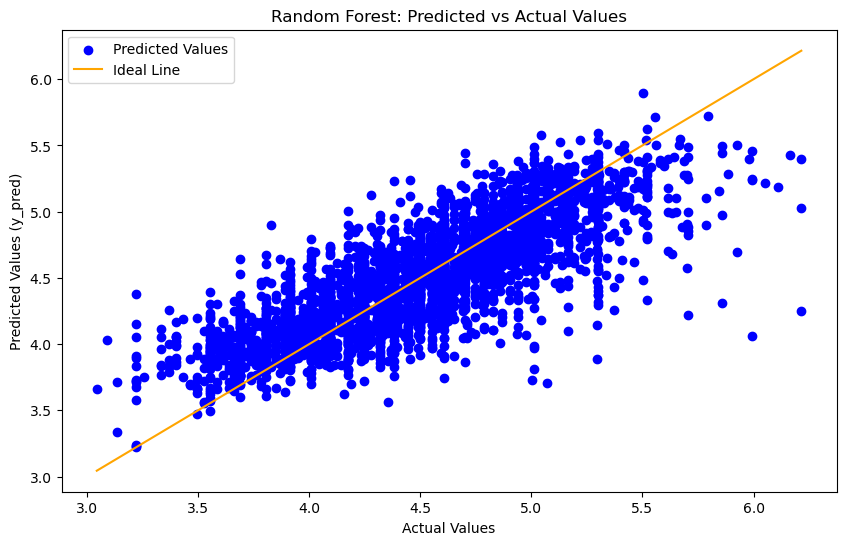

In [41]:
y = df['log_price'] 
X = df.drop(columns=['log_price', 'name','first_review', 'last_review', 'host_since'])

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)


# Visualize actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linestyle='-', label='Ideal Line')
plt.title('Random Forest: Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values (y_pred)')
plt.legend()
plt.show()

In [43]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)

# Fitting the model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluating the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Root Mean Squared Error: 0.3020380694249631
R-squared: 0.6410211901258474


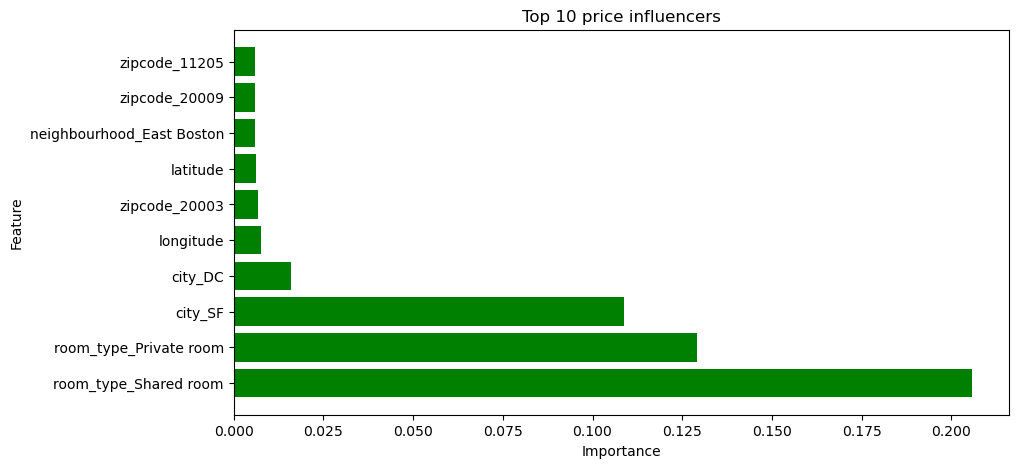

In [45]:


# Create a DataFrame of feature importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_})

# Sort by importance and show top 10
top_10_features = feature_importance.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 5))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 price influencers')
plt.show()

Insights
When hosting "Shared rooms" or "Private rooms," revisit the pricing strategy to stay ahead of the competition. 

For places near tourist hotspots or downtown areas, emphasize the awesome location—that alone can justify a higher price. 

Highlight unique number of amenities and features to stand out in the most popular neighborhoods!

link for the Video Presentation of the Project
https://drive.google.com/file/d/11h-w5p4qMNS0iG1VE83sGvCNaR-mLrkI/view?usp=sharing